In [47]:
# If using Jupyter, you can set your Kaggle credentials here:
import os

os.environ['KAGGLE_USERNAME'] = "theepanhrithik"
os.environ['KAGGLE_KEY'] = "22caa924b4824eed41dc9a6e16a0380d"


In [48]:
def load_dataset(input_path: str, kaggle_csv_name: str = None) -> pd.DataFrame:
    """
    Unified dataset loader for Kaggle, HTTP(s), and local paths.

    Args:
        input_path (str): URL, file path, or Kaggle dataset link.
        kaggle_csv_name (str): Specific CSV file name inside Kaggle dataset (optional).

    Returns:
        pd.DataFrame: Loaded dataset.
    """
    
    # Case 1: Kaggle URL
    if "kaggle.com/datasets/" in input_path:
        return load_kaggle_dataset(input_path, file_name=kaggle_csv_name)

    # Case 2: Direct HTTP(S) link
    elif input_path.startswith("http://") or input_path.startswith("https://"):
        response = requests.get(input_path)
        if response.status_code != 200:
            raise Exception(f"Failed to download file. Status code: {response.status_code}")
        filename = urlparse(input_path).path.split("/")[-1]
        with open(filename, 'wb') as f:
            f.write(response.content)
        return pd.read_csv(filename)

    # Case 3: Local file
    elif os.path.isfile(input_path):
        return pd.read_csv(input_path)

    # Case 4: Unknown format
    else:
        raise ValueError("Unsupported input. Provide a Kaggle URL, HTTP(s) URL, or local file path.")


STEP 2 

In [49]:
import pandas as pd
import numpy as np
from typing import Dict, Any

def profile_dataset(df: pd.DataFrame, target_column: str) -> Dict[str, Any]:
    """
    Profiles a dataset to infer task type, data types, missing values, duplicates, etc.

    Args:
        df (pd.DataFrame): Loaded dataset.
        target_column (str): Name of the target column.

    Returns:
        Dict[str, Any]: Profile summary dictionary.
    """
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")
    
    profile = {}

    # Basic stats
    profile['target'] = target_column
    profile['n_rows'], profile['n_columns'] = df.shape
    profile['duplicates'] = df.duplicated().sum()

    # Null value summary
    null_counts = df.isnull().sum()
    profile['null_summary'] = null_counts[null_counts > 0].to_dict()

    # Data type breakdown
    dtype_summary = {
        "numerical": [],
        "categorical": [],
        "binary": []
    }
    for col in df.columns:
        if col == target_column:
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            dtype_summary["numerical"].append(col)
        elif df[col].nunique() == 2:
            dtype_summary["binary"].append(col)
        else:
            dtype_summary["categorical"].append(col)
    profile["dtype_summary"] = dtype_summary

    # Target column analysis
    target_series = df[target_column]
    target_dtype = target_series.dtype

    if pd.api.types.is_numeric_dtype(target_dtype):
        unique_vals = target_series.nunique()
        if unique_vals == 2:
            task_type = "binary_classification"
        elif unique_vals <= 10:
            task_type = "multi_class_classification"
        else:
            task_type = "regression"
    elif pd.api.types.is_string_dtype(target_dtype):
        if target_series.str.len().mean() > 30:
            task_type = "nlp"
        else:
            task_type = "multi_class_classification"
    elif pd.api.types.is_datetime64_any_dtype(target_dtype):
        task_type = "time_series"
    else:
        task_type = "unknown"

    profile["target_type"] = task_type

    # Class balance (for classification tasks)
    if "classification" in task_type:
        class_counts = target_series.value_counts(normalize=True) * 100
        profile["class_balance"] = class_counts.round(2).to_dict()

    # Suggested metrics
    if task_type == "regression":
        profile["suggested_metrics"] = ["rmse", "mae", "r2_score"]
    elif task_type == "binary_classification":
        profile["suggested_metrics"] = ["accuracy", "f1", "roc_auc"]
    elif task_type == "multi_class_classification":
        profile["suggested_metrics"] = ["accuracy", "f1_macro"]
    elif task_type == "nlp":
        profile["suggested_metrics"] = ["f1", "bleu", "rouge"]
    elif task_type == "time_series":
        profile["suggested_metrics"] = ["mape", "rmse"]
    else:
        profile["suggested_metrics"] = []

    return profile


Step3 

In [50]:
import os
import glob
import openai
import chromadb
from chromadb import Client
from dotenv import load_dotenv

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document

# 1. Load environment variables
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# 2. Initialize Chroma (local, in-memory client)
chroma_client = Client()
collection = chroma_client.get_or_create_collection(name="rules")

# 3. Load all .md rule files
rules_folder = "D:/Studies/Langchain/Project/Langgraph/rules"  # update if needed
md_files = glob.glob(os.path.join(rules_folder, "*.md"))

documents = []
for path in md_files:
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
        documents.append(Document(page_content=text, metadata={"source": os.path.basename(path)}))

# 4. Split into semantic chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(documents)

# 5. Generate embeddings using OpenAI
embedder = OpenAIEmbeddings(model="text-embedding-3-small")
texts = [chunk.page_content for chunk in chunks]
metadatas = [chunk.metadata for chunk in chunks]

# 6. Add to Chroma collection
collection.add(
    documents=texts,
    metadatas=metadatas,
    ids=[f"doc_{i}" for i in range(len(texts))]
)

print(f"✅ Successfully embedded {len(texts)} chunks from {len(md_files)} rule files.")


✅ Successfully embedded 266 chunks from 40 rule files.


Step 3.2

In [51]:
from typing import Dict, List

def retrieve_rules(profile: Dict, chroma_client, top_k=5, score_threshold=0.75) -> Dict[str, List[str]]:
    """
    Retrieves relevant rules for each pipeline stage using ChromaDB and profile data.

    Args:
        profile (Dict): Output from profile_dataset().
        chroma_client: Initialized Chroma Client.
        top_k (int): Number of top results per query.
        score_threshold (float): Similarity threshold to avoid fallback.

    Returns:
        Dict[str, List[str]]: Retrieved rules + fallback flag.
    """
    collection = chroma_client.get_or_create_collection("rules")
    task = profile.get("target_type", "")
    dtypes = profile.get("dtype_summary", {})
    nulls = list(profile.get("null_summary", {}).keys())

    # Create queries
    queries = {
        "cleaning_rules": f"data cleaning rules for {task} with missing values in {nulls}",
        "feature_engineering_rules": f"feature engineering for {task} with numerical: {dtypes.get('numerical')}, categorical: {dtypes.get('categorical')}",
        "modeling_rules": f"model selection and training rules for {task}",
        "evaluation_rules": f"evaluation metrics and explanation for {task} task"
    }

    results = {}
    fallback_triggered = False

    for key, query in queries.items():
        search_result = collection.query(query_texts=[query], n_results=top_k, include=["documents", "distances"])
        docs = search_result['documents'][0]
        scores = search_result['distances'][0]

        # Fallback logic
        if len(docs) < 2 or max(scores) < score_threshold:
            fallback_triggered = True

        results[key] = docs

    results["fallback_triggered"] = fallback_triggered
    return results


Step 4 

Search Query Generator (LLM Prompt)

In [52]:
from openai import OpenAI
from typing import Dict

def generate_search_query(profile: Dict, topic_key: str, model="gpt-3.5-turbo") -> str:
    """
    Generates a web search query using LLM based on topic and profile context.

    Args:
        profile (Dict): Output from profile_dataset().
        topic_key (str): Which topic needs fallback (e.g., 'outlier handling in regression').
        model (str): LLM model name.

    Returns:
        str: Natural search query.
    """
    system_msg = "You are a helpful assistant that rewrites technical data science topics into effective Google search queries."
    user_msg = f"""Generate a Google search query to help a data scientist retrieve high-quality articles for the following topic: "{topic_key}". 
    The ML task is: {profile.get('target_type', 'unknown')}.
    The dataset has numerical: {profile.get('dtype_summary', {}).get('numerical')}, categorical: {profile.get('dtype_summary', {}).get('categorical')} features.
    Make the query as realistic and focused as possible.
    """

    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_msg},
            {"role": "user", "content": user_msg}
        ],
        temperature=0.7
    )

    return response.choices[0].message.content.strip()


In [53]:
query = generate_search_query(profile, topic_key="outlier handling in regression")
print(query)
# Output: "best methods to detect and treat outliers in regression datasets using Python"


"Best practices for handling outliers in regression for binary classification with numerical features pclass age sibsp parch fare adult_male alone and categorical features embarked class who deck embark_town"


In [54]:
from serpapi import GoogleSearch
from dotenv import load_dotenv
import os

def search_serpapi(query: str, num_results: int = 5):
    """
    Searches Google using SerpAPI and returns top result snippets.

    Args:
        query (str): Search query string.
        num_results (int): Number of results to return.

    Returns:
        List[Dict]: List of results with title, snippet, and link.
    """
    load_dotenv()
    api_key = os.getenv("SERPAPI_KEY")
    
    params = {
        "q": query,
        "api_key": api_key,
        "engine": "google",
        "num": num_results,
    }

    search = GoogleSearch(params)
    results = search.get_dict()

    # Extract organic results
    snippets = []
    for res in results.get("organic_results", [])[:num_results]:
        snippets.append({
            "title": res.get("title"),
            "snippet": res.get("snippet"),
            "link": res.get("link")
        })
    
    return snippets


4.3: Summarize Web Results using OpenAI

In [55]:
from openai import OpenAI
from typing import List

def summarize_search_snippets(snippets: List[Dict], model="gpt-3.5-turbo") -> str:
    """
    Uses OpenAI to summarize web snippets into a fallback explanation.

    Args:
        snippets (List[Dict]): SerpAPI snippets (title, snippet, link).
        model (str): LLM model to use.

    Returns:
        str: Clean fallback summary.
    """
    combined = "\n\n".join(
        [f"{i+1}. {item['title']} — {item['snippet']}" for i, item in enumerate(snippets)]
    )

    prompt = f"""
You are a helpful data science assistant. Read the following 5 web snippets and summarize the best practices for the topic in 1-2 short paragraphs. 
Focus on what a data scientist needs to know to handle this in real projects.

Snippets:
{combined}

Summary:
"""

    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )

    return response.choices[0].message.content.strip()


Step 4.4: Bundle Everything into run_web_fallback()

This function will:

Generate the fallback query from the dataset profile

Search SerpAPI for top links/snippets

Summarize the results with GPT

Return the summary (optionally also save it to ChromaDB if needed)

In [56]:
from typing import Dict, List
import os
import openai
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from serpapi import GoogleSearch

openai.api_key = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o", temperature=0)

def search_serpapi(query: str, num_results: int = 5) -> List[Dict[str, str]]:
    params = {
        "engine": "google",
        "q": query,
        "api_key": os.getenv("SERPAPI_API_KEY"),
        "num": num_results
    }
    search = GoogleSearch(params)
    results = search.get_dict()
    organic = results.get("organic_results", [])
    return [{"title": r.get("title"), "link": r.get("link"), "snippet": r.get("snippet")} for r in organic]

def summarize_with_llm(results: List[Dict[str, str]]) -> str:
    context = "\n\n".join([f"{r['title']}\n{r['snippet']}\n{r['link']}" for r in results])
    prompt = (
        "Summarize the following search results into clear data science rules or steps. "
        "Only include practical steps or insights that could be useful for data preprocessing or modeling:\n\n"
        f"{context}"
    )
    response = llm([HumanMessage(content=prompt)])
    return response.content.strip()

def retrieve_rules_with_fallback(profile: Dict, chroma_client, top_k=5, score_threshold=0.75) -> Dict[str, List[str]]:
    """
    Tries to retrieve rules from ChromaDB. If fallback needed, searches the web,
    summarizes using GPT, stores the fallback summary, and returns all results.
    """
    collection = chroma_client.get_or_create_collection("rules")
    task = profile.get("target_type", "")
    dtypes = profile.get("dtype_summary", {})
    nulls = list(profile.get("null_summary", {}).keys())

    queries = {
        "cleaning_rules": f"data cleaning rules for {task} with missing values in {nulls}",
        "feature_engineering_rules": f"feature engineering for {task} with numerical: {dtypes.get('numerical')}, categorical: {dtypes.get('categorical')}",
        "modeling_rules": f"model selection and training rules for {task}",
        "evaluation_rules": f"evaluation metrics and explanation for {task} task"
    }

    results = {}
    fallback_triggered = False

    for key, query in queries.items():
        search_result = collection.query(query_texts=[query], n_results=top_k, include=["documents", "distances"])
        docs = search_result['documents'][0]
        scores = search_result['distances'][0]

        if len(docs) < 2 or max(scores) < score_threshold:
            fallback_triggered = True
            print(f"🔍 Fallback triggered for {key} → Performing web search...")

            serp_results = search_serpapi(query)
            summary = summarize_with_llm(serp_results)

            # Store fallback summary for future
            collection.add(documents=[summary], ids=[f"{key}_fallback_{os.urandom(4).hex()}"])
            results[key] = [summary]
        else:
            results[key] = docs

    results["fallback_triggered"] = fallback_triggered
    return results


Step5 Data Pipeline

In [57]:
import pandas as pd
import re
from typing import List

def apply_cleaning_rules(df: pd.DataFrame, rules: List[str]) -> pd.DataFrame:
    """
    Apply rule-based data cleaning to a dataframe.

    Args:
        df (pd.DataFrame): Input dataframe
        rules (List[str]): List of text-based rules (markdown lines)

    Returns:
        pd.DataFrame: Cleaned dataframe
    """
    df = df.copy()

    for rule in rules:
        rule = rule.lower().strip()

        # Rule 1: Drop rows with missing target
        if re.search(r"drop rows.*missing.*target", rule):
            target_col = df.columns[-1]  # assuming target is last
            df = df.dropna(subset=[target_col])

        # Rule 2: Drop specific columns
        m = re.search(r"drop ['\"]?(\w+)['\"]?", rule)
        if m and m.group(1) in df.columns:
            df.drop(columns=[m.group(1)], inplace=True)

        # Rule 3: Impute numerical columns with median
        m = re.search(r"impute ['\"]?(\w+)['\"]?.*median", rule)
        if m and m.group(1) in df.columns:
            col = m.group(1)
            df[col].fillna(df[col].median(), inplace=True)

        # Rule 4: Fill missing with 'unknown' for categoricals
        m = re.search(r"fill ['\"]?(\w+)['\"]?.*with.*unknown", rule)
        if m and m.group(1) in df.columns:
            col = m.group(1)
            df[col].fillna("Unknown", inplace=True)

    return df


Step 6: Rule-Based Feature Engineering

In [58]:
import pandas as pd
import re
from typing import List, Tuple

def apply_feature_engineering(df: pd.DataFrame, rules: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    """
    Applies rule-based feature engineering from markdown instructions.

    Args:
        df (pd.DataFrame): Cleaned dataset.
        rules (List[str]): Feature engineering markdown rules.

    Returns:
        Tuple[pd.DataFrame, List[str]]: Transformed DataFrame and applied rule log.
    """
    log = []
    
    # Rule: Drop constant features
    for col in df.columns:
        if df[col].nunique() == 1:
            df = df.drop(columns=[col])
            log.append(f"Dropped constant column: {col}")

    # Rule: One-hot encode categoricals (simple version)
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    log.append(f"One-hot encoded columns: {list(categorical_cols)}")

    # Rule: Scale numeric columns to [0, 1]
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    for col in numeric_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df[col] = (df[col] - min_val) / (max_val - min_val)
            log.append(f"Min-max scaled: {col}")
        else:
            log.append(f"Skipped scaling (constant): {col}")

    return df, log


In [68]:
df_fe, fe_log = apply_feature_engineering(df_cleaned, retrieved["feature_engineering_rules"])


In [69]:
# 🔍 Check if there are any missing values
print("NaNs in each column:")
print(df_fe.isnull().sum())

# 🩹 Fix: Impute missing values
# Fill numeric columns with median
numeric_cols = df_fe.select_dtypes(include='number').columns
df_fe[numeric_cols] = df_fe[numeric_cols].fillna(df_fe[numeric_cols].median())

# Fill categorical columns with mode
cat_cols = df_fe.select_dtypes(include='object').columns
for col in cat_cols:
    if df_fe[col].isnull().any():
        mode = df_fe[col].mode()
        if not mode.empty:
            df_fe[col].fillna(mode[0], inplace=True)
        else:
            print(f"⚠️ Column '{col}' has all NaNs, can't fill with mode.")


NaNs in each column:
survived                     0
pclass                       0
age                        177
sibsp                        0
parch                        0
fare                         0
adult_male                   0
alone                        0
sex_male                     0
embarked_Q                   0
embarked_S                   0
class_Second                 0
class_Third                  0
who_man                      0
who_woman                    0
deck_B                       0
deck_C                       0
deck_D                       0
deck_E                       0
deck_F                       0
deck_G                       0
embark_town_Queenstown       0
embark_town_Southampton      0
alive_yes                    0
dtype: int64


In [59]:
# Step 5 — Clean raw df
df_cleaned = apply_cleaning_rules(df, retrieved["cleaning_rules"])

# Step 6 — Feature engineering
df_fe, fe_log = apply_feature_engineering(df_cleaned, retrieved["feature_engineering_rules"])

# Save the result
df_fe.to_csv("engineered_data.csv", index=False)

# Show what was done
print("\n".join(fe_log))


One-hot encoded columns: ['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive']
Min-max scaled: survived
Min-max scaled: pclass
Min-max scaled: age
Min-max scaled: sibsp
Min-max scaled: parch
Min-max scaled: fare


Step 7 – Train & Evaluate Model Based on Retrieved Rules
This function:

Chooses the right model (e.g. Logistic Regression, Random Forest, etc.)

Trains using engineered features

Evaluates with appropriate metrics

Logs the results

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

def train_and_evaluate(df: pd.DataFrame, profile: dict, modeling_rules: List[str], evaluation_rules: List[str]):
    target = profile["target_column"]
    X = df.drop(columns=[target])
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Choose model based on rules (for now, hardcoded for demo)
    if any("logistic" in rule.lower() for rule in modeling_rules):
        model = LogisticRegression(max_iter=1000)
        model_name = "Logistic Regression"
    else:
        model = RandomForestClassifier(n_estimators=100)
        model_name = "Random Forest"

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)

    print(f"\n✅ Model: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", report)

    return model


In [70]:
model = train_and_evaluate(
    df=df_fe,
    profile=profile,
    modeling_rules=retrieved["modeling_rules"],
    evaluation_rules=retrieved["evaluation_rules"]
)



✅ Model: Logistic Regression
Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       105
         1.0       1.00      1.00      1.00        74

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



<Axes: >

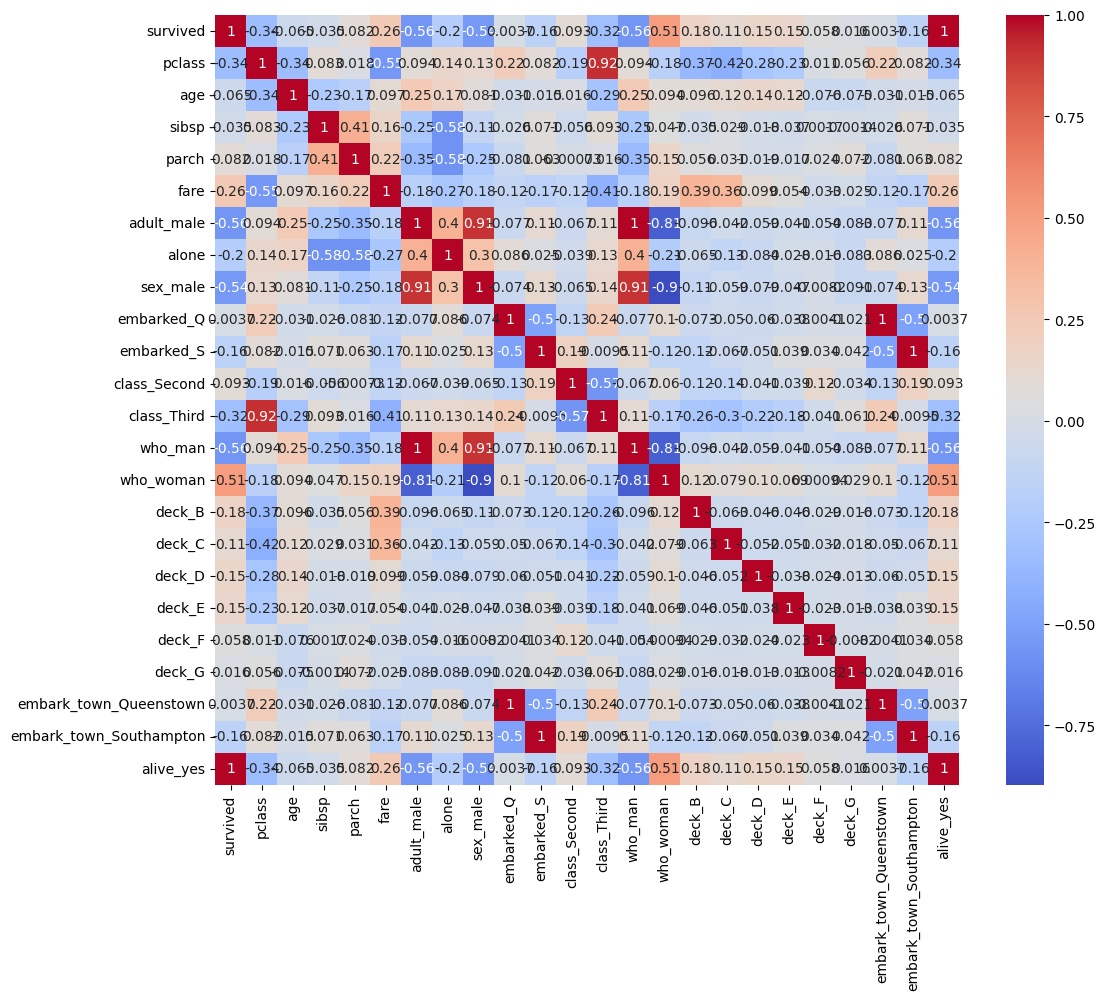

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(df_fe.corr(), annot=True, cmap="coolwarm")


In [75]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
selector.fit(df_fe.drop(columns=["survived"]))
print("Features with 0 variance:", df_fe.drop(columns=["survived"]).columns[~selector.get_support()])


Features with 0 variance: Index([], dtype='object')


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error, f1_score

def build_pipeline(df, profile, rules_dict):
    target = profile['target']
    X = df.drop(columns=[target])
    y = df[target]

    # -- Handle missing values --
    numeric_features = profile['dtype_summary']['numerical']
    categorical_features = profile['dtype_summary']['categorical']

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    # -- Choose model based on task --
    task_type = profile['target_type']
    if task_type == "binary_classification":
        model = LogisticRegression(max_iter=1000)
    elif task_type == "multi_class_classification":
        model = RandomForestClassifier()
    elif task_type == "regression":
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
    else:
        raise ValueError(f"Unsupported task type: {task_type}")

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # -- Split data --
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # -- Train and evaluate --
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n🧠 Model trained for task: {task_type}")
    if "classification" in task_type:
        print(classification_report(y_test, y_pred))
    elif task_type == "regression":
        print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

    return clf


In [87]:
# Load Titanic dataset
import pandas as pd
import seaborn as sns
df = sns.load_dataset('titanic')
target_column = "survived"

# Profile dataset
profile = profile_dataset(df, target_column)

# Initialize chroma
from chromadb import Client
chroma_client = Client()

# Retrieve rules
retrieved_rules = retrieve_rules(profile, chroma_client)


In [88]:
pipeline_model = build_pipeline(df, profile, retrieved_rules)



🧠 Model trained for task: binary_classification
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



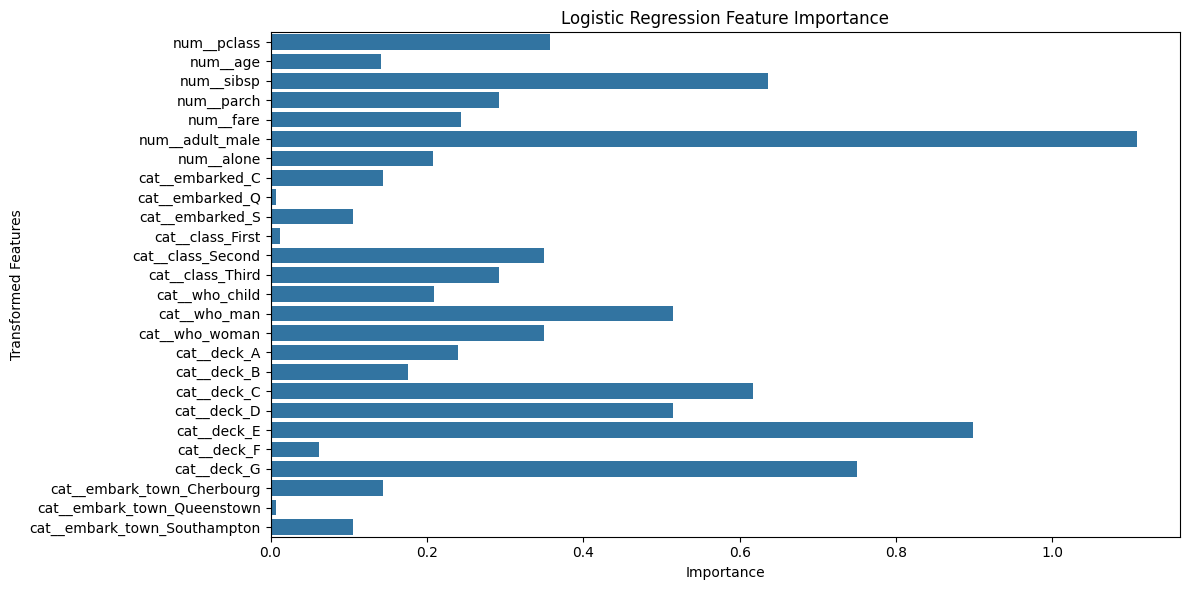

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get trained model
model = pipeline_model.named_steps['model']

# Get preprocessor (like ColumnTransformer)
preprocessor = pipeline_model.named_steps['preprocessor']

# Get transformed feature names
try:
    # For scikit-learn >= 1.0
    feature_names = preprocessor.get_feature_names_out()
except:
    # Fallback for older versions
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(columns))
        else:
            feature_names.extend(columns)

# Get importances from logistic regression model
if hasattr(model, 'coef_'):
    feature_importance = np.abs(model.coef_)[0]

    # Check shape match
    if len(feature_names) == len(feature_importance):
        # Plotting
        plt.figure(figsize=(12, 6))
        sns.barplot(x=feature_importance, y=feature_names)
        plt.title("Logistic Regression Feature Importance")
        plt.xlabel("Importance")
        plt.ylabel("Transformed Features")
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Mismatch: model input features ≠ importance vector size")
        print(f"Features: {len(feature_names)}, Coefficients: {len(feature_importance)}")
else:
    print("❌ This model does not support feature importance.")


Profiler Agent (as Agent Tool)

In [94]:
def profiler_agent(df, target_column=None):
    profile = {}

    # Column types
    profile['numerical_columns'] = df.select_dtypes(include=['number']).columns.tolist()
    profile['categorical_columns'] = df.select_dtypes(include=['object', 'category']).columns.tolist()
    profile['datetime_columns'] = df.select_dtypes(include=['datetime']).columns.tolist()

    # Target column auto-detect if not given
    if target_column is None:
        target_column = df.columns[-1]
    profile['target'] = target_column

    # Task type inference
    n_unique = df[target_column].nunique()
    if df[target_column].dtype == 'object' or n_unique <= 10:
        profile['task_type'] = 'classification'
    elif df[target_column].dtype == 'number' and n_unique > 20:
        profile['task_type'] = 'regression'
    else:
        profile['task_type'] = 'unknown'

    # Nulls
    profile['null_percent'] = df.isnull().mean().round(3).to_dict()

    # Class balance (for classification)
    if profile['task_type'] == 'classification':
        profile['class_distribution'] = df[target_column].value_counts(normalize=True).round(3).to_dict()

    # Skewness
    profile['skewness'] = df.skew(numeric_only=True).round(3).to_dict()

    return profile


In [96]:
import pandas as pd

df = pd.read_csv("Titanic.csv")
profile = profiler_agent(df, target_column='Survived')


In [97]:
from pprint import pprint
pprint(profile)


{'categorical_columns': ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'],
 'class_distribution': {0: 0.616, 1: 0.384},
 'datetime_columns': [],
 'null_percent': {'Age': 0.199,
                  'Cabin': 0.771,
                  'Embarked': 0.002,
                  'Fare': 0.0,
                  'Name': 0.0,
                  'Parch': 0.0,
                  'PassengerId': 0.0,
                  'Pclass': 0.0,
                  'Sex': 0.0,
                  'SibSp': 0.0,
                  'Survived': 0.0,
                  'Ticket': 0.0},
 'numerical_columns': ['PassengerId',
                       'Survived',
                       'Pclass',
                       'Age',
                       'SibSp',
                       'Parch',
                       'Fare'],
 'skewness': {'Age': 0.389,
              'Fare': 4.787,
              'Parch': 2.749,
              'PassengerId': 0.0,
              'Pclass': -0.631,
              'SibSp': 3.695,
              'Survived': 0.479},
 'target':

In [98]:
from langchain.tools import tool
import pandas as pd
from helpers.dataset_utils import load_dataset  # your utility function

@tool
def dataset_loader_agent(input_path: str, kaggle_csv_name: str = None) -> str:
    """
    Agent that loads dataset from Kaggle, URL, or local path.
    Returns path to saved CSV.
    """
    df = load_dataset(input_path, kaggle_csv_name)
    df.to_csv("loaded_dataset.csv", index=False)
    return "loaded_dataset.csv"


ModuleNotFoundError: No module named 'helpers'